# 군집분석 및 최종 설치 위치 선정
* 점포들(카페, 편의점)을 KMeans 알고리즘을 사용하여 군집화
 * 최적의 k 값을 보여주는 Elbow-Method 시각화
* 클러스터의 점수화
* 시각화
 * 점포(빨간색)
 * 클러스터(상위 점수 - 주황색 / 하위 점수 - 초록색)
 * 승차 인원에 따른 버스정류장 구분(8만명 이상 - 검붉은색 / 8만명 미만 & 5만명 이상 - 분홍색)

In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
from haversine import haversine
from sklearn.cluster import KMeans
from tqdm import tqdm

## 데이터 로드 

In [2]:
# 점포 데이터
url = './1. 점포_전처리.xlsx'
cafe_df = pd.read_excel(url, sheet_name='카페')
conv_df = pd.read_excel(url, sheet_name='편의점')
bakery_df = pd.read_excel(url, sheet_name='베이커리')
store_df = cafe_df.append(conv_df)
store_df = store_df.append(bakery_df)
store_df.index = range(len(store_df)) # 인덱스 정리
store_df

,사업장명,도로명주소,업태구분명,x,y,경도,위도,Unnamed: 0
0,배스킨라빈스,서울특별시 서대문구 증가로 140 (남가좌동),기타 휴게음식점,193042.666990,452830.718334,126.922027,37.577745,NaN
1,베스킨라빈스,서울특별시 서대문구 통일로 203 (영천동286),기타 휴게음식점,196479.378250,452110.388281,126.960936,37.571275,NaN
2,공차이대익스프레스점,서울특별시 서대문구 이화여대길 48 1층 (대현동),기타 휴게음식점,195155.264764,450709.840434,126.945957,37.558650,NaN
3,배스킨라빈스 연대점,서울특별시 서대문구 연세로 29-1 (창천동1층),기타 휴게음식점,194342.107778,450674.660332,126.936754,37.558328,NaN
4,베스킨라빈스 홍제삼거리점,서울특별시 서대문구 통일로 420 (홍제동 1층),기타 휴게음식점,195206.832766,453852.542097,126.946520,37.586966,NaN
...,...,...,...,...,...,...,...,...
816,글룩베이커리,서울특별시 서대문구 명지대7길 19 1층 (남가좌동),제과점영업,193050.383068,453504.344166,126.922108,37.583815,1218.0
817,뚜레쥬르 충암점,서울특별시 서대문구 가좌로 141 1층 (홍은동),제과점영업,193183.651737,453583.312173,126.923616,37.584527,1219.0
818,더파이홀2,서울특별시 서대문구 연세로5나길 18 3층 (창천동),제과점영업,194201.714525,450534.090429,126.935166,37.557061,1220.0
819,달다구리 제작소,서울특별시 서대문구 통일로27길 5 1층 3호 (홍제동),제과점영업,195432.285773,453467.338107,126.949075,37.583496,1221.0


In [3]:
# 버스 데이터
url = './2. 버스정류장_전처리.xlsx'
bus_df = pd.read_excel(url)
bus_df

,Unnamed: 0,버스정류장번호,승차총승객수,하차총승객수,승하차총승객수,정류소명,경도,위도
0,0,13911,114636,80588,195224,홍제역.3번출구,126.944321,37.588500
1,1,13028,108947,109220,218167,홍제역,126.944350,37.588479
2,2,13029,108056,87437,195493,홍제역,126.945368,37.587879
3,3,13802,106088,47311,153399,신촌전철역,126.937262,37.555450
4,4,13021,99108,52219,151327,신촌오거리.현대백화점,126.934527,37.556026
...,...,...,...,...,...,...,...,...
452,452,13882,8,3885,3893,홍은2동어린이집앞,126.934155,37.579578
453,375,13336,2,290,292,서대문구의회앞,126.953720,37.575857
454,455,13907,2,913,915,홍은동국민주택,126.949971,37.605549
455,456,13859,2,543,545,명지고후문,126.929216,37.584159


## 점포들 클러스터링 & 점수화

### Elbow Method

In [4]:
x_data = store_df[['위도', '경도']]

inertia = []

for i in range(1,30):
    kmean = KMeans(n_clusters=i, random_state=10)
    kmean.fit(x_data)
    inertia.append(kmean.inertia_)
inertia

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[0.2929997466588797,
 0.15580664153327137,
 0.0873471025635935,
 0.049219513487471556,
 0.0343015527807356,
 0.027391739490937404,
 0.023164227487194513,
 0.019200899441377282,
 0.016934619152699608,
 0.014911525837593108,
 0.012784310396190175,
 0.011332012391360918,
 0.01025808947294825,
 0.009249746195497854,
 0.008526693175629796,
 0.007792218828066155,
 0.007063285154623532,
 0.0068479712523992495,
 0.006045421985764933,
 0.005761060509468888,
 0.005434095481081109,
 0.0052875363893636505,
 0.00496439320696695,
 0.004587526851031303,
 0.00451550424923015,
 0.004236441989664351,
 0.004020045244709926,
 0.0038728713777727206,
 0.0038176052397566403]

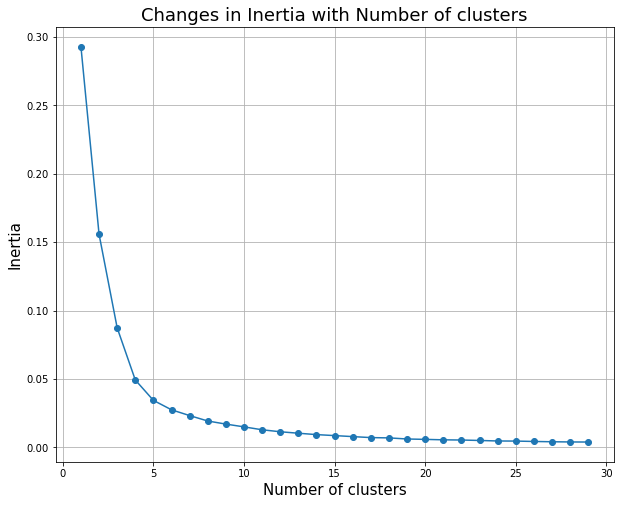

In [5]:
plt.figure(figsize=(10,8))
plt.plot(range(1,30), inertia, marker='o')
plt.grid()

plt.title('Changes in Inertia with Number of clusters', fontsize=18)
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Inertia', fontsize=15)

plt.show()

### 클러스터 점수

In [6]:
# KMeans 알고리즘을 이용한 군집화
k = 15
kmean = KMeans(n_clusters=k, random_state=10)
kmean.fit(x_data)

KMeans(n_clusters=15, random_state=10)

In [7]:
centers = kmean.cluster_centers_
centers

array([[ 37.57169329, 126.9150089 ],
       [ 37.57985314, 126.93559263],
       [ 37.56016465, 126.95403134],
       [ 37.55890035, 126.94527876],
       [ 37.58782278, 126.94490985],
       [ 37.56822168, 126.92998431],
       [ 37.57634255, 126.92164574],
       [ 37.55729191, 126.93674343],
       [ 37.59652287, 126.94775135],
       [ 37.58071557, 126.91167121],
       [ 37.56301925, 126.96488546],
       [ 37.58140581, 126.92461107],
       [ 37.56486111, 126.94130689],
       [ 37.56170782, 126.92921321],
       [ 37.57002997, 126.95966232]])

In [8]:
# 군집 내 점포 개수를 구하기 위해 군집의 중심과 점포들의 거리 각각 계산
col = ['클러스터번호', '클러스터_위도', '클러스터_경도', '도로명주소', '가게_위도', '가게_경도', '거리']
cluster_store_df = pd.DataFrame(columns=col)

for i in tqdm(range(len(centers))):
    for j in range(len(store_df)):
        cent = (centers[i,0], centers[i,1])
        store = (store_df['위도'][j], store_df['경도'][j])
        distnace = haversine(cent, store)

        new_row = {
            '클러스터번호':i, '클러스터_위도':centers[i,0], '클러스터_경도':centers[i,1],
            '도로명주소':store_df['도로명주소'][j], '가게_위도':store_df['위도'][j], '가게_경도':store_df['경도'][j], 
            '거리':distnace
        }

        cluster_store_df = cluster_store_df.append(new_row, ignore_index=True)

cluster_store_df

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:50<00:00,  3.39s/it]


,클러스터번호,클러스터_위도,클러스터_경도,도로명주소,가게_위도,가게_경도,거리
0,0,37.571693,126.915009,서울특별시 서대문구 증가로 140 (남가좌동),37.577745,126.922027,0.913987
1,0,37.571693,126.915009,서울특별시 서대문구 통일로 203 (영천동286),37.571275,126.960936,4.047926
2,0,37.571693,126.915009,서울특별시 서대문구 이화여대길 48 1층 (대현동),37.558650,126.945957,3.089345
3,0,37.571693,126.915009,서울특별시 서대문구 연세로 29-1 (창천동1층),37.558328,126.936754,2.425263
4,0,37.571693,126.915009,서울특별시 서대문구 통일로 420 (홍제동 1층),37.586966,126.946520,3.254951
...,...,...,...,...,...,...,...
12310,14,37.570030,126.959662,서울특별시 서대문구 명지대7길 19 1층 (남가좌동),37.583815,126.922108,3.647267
12311,14,37.570030,126.959662,서울특별시 서대문구 가좌로 141 1층 (홍은동),37.584527,126.923616,3.562246
12312,14,37.570030,126.959662,서울특별시 서대문구 연세로5나길 18 3층 (창천동),37.557061,126.935166,2.596432
12313,14,37.570030,126.959662,서울특별시 서대문구 통일로27길 5 1층 3호 (홍제동),37.583496,126.949075,1.764302


In [9]:
# 클러스터 반경 설정을 500m로 하기 때문에 500m 이하인 것들 파씽
distance_500 = cluster_store_df[cluster_store_df['거리'] <= 0.5]

# 클러스터번호가 같은 것 끼리 묶기 -> 클러스터 내 점포 개수
group = distance_500.groupby(['클러스터번호']).count()
group

,클러스터_위도,클러스터_경도,도로명주소,가게_위도,가게_경도,거리
클러스터번호,,,,,,
0,37,37,37,37,37,37
1,33,33,33,33,33,33
2,36,36,36,36,36,36
3,99,99,95,99,99,99
4,49,49,48,49,49,49
5,79,79,79,79,79,79
6,59,59,59,59,59,59
7,79,79,79,79,79,79
8,43,43,43,43,43,43


In [10]:
# 클러스터 점수
col = ['클러스터번호', '위도', '경도', '군집 내 점포개수', '점수']
clusters_score_df = pd.DataFrame(columns=col)

for i in tqdm(range(len(centers))):
    cluster_score = int(group.iloc[i,0] / 10)
    new_row = {
        '클러스터번호' : i, '위도' : centers[i,0], '경도' : centers[i,1],
        '군집 내 점포개수' : group.iloc[i,1], '점수' : cluster_score
              }
    
    clusters_score_df = clusters_score_df.append(new_row, ignore_index=True)
    
clusters_score_df

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.28it/s]


,클러스터번호,위도,경도,군집 내 점포개수,점수
0,0.0,37.571693,126.915009,37.0,3.0
1,1.0,37.579853,126.935593,33.0,3.0
2,2.0,37.560165,126.954031,36.0,3.0
3,3.0,37.558900,126.945279,99.0,9.0
4,4.0,37.587823,126.944910,49.0,4.0
5,5.0,37.568222,126.929984,79.0,7.0
6,6.0,37.576343,126.921646,59.0,5.0
7,7.0,37.557292,126.936743,79.0,7.0
8,8.0,37.596523,126.947751,43.0,4.0
9,9.0,37.580716,126.911671,49.0,4.0


In [11]:
# 점수가 높은 클러스터
cluster_high_df = clusters_score_df[clusters_score_df['점수'] >= 5]
cluster_high_df.index = range(len(cluster_high_df))

# 점수가 낮은 클러스터
cluster_low_df = clusters_score_df[clusters_score_df['점수'] < 5]
cluster_low_df.index = range(len(cluster_low_df))

In [12]:
clusters_score_df.to_excel('3-1. 클러스터 점수.xlsx')

### 승차 인원에 따른 버스정류장 분류

In [13]:
# bus_df[(bus_df['승차총승객수'] < 80000) & (bus_df['승차총승객수'] >= 50000)]

In [14]:
# 승차 인원이 8만명 이상인 버스정류장 
bus_high_df = bus_df[bus_df['승차총승객수'] >= 80000]
bus_high_df.index = range(len(bus_high_df))

# 승차인원이 5만명 이상, 8만명 미만
bus_middle_df = bus_df[(bus_df['승차총승객수'] < 80000) & (bus_df['승차총승객수'] >= 50000)]
bus_middle_df.index = range(len(bus_middle_df))


## 시각화
 * 점포(빨간색)
 * 클러스터(상위 점수 - 주황색 / 하위 점수 - 초록색)
 * 승차 인원에 따른 버스정류장 구분(8만명 이상 - 검붉은색 / 8만명 미만 & 5만명 이상 - 분홍색)

In [15]:
map = folium.Map([37.579966884194555, 126.94064611814223], zoom_start = 14)

In [16]:
# 점포
for i in range(len(store_df)):
    folium.Circle([store_df['위도'][i], store_df['경도'][i]],
                 color='red',
                 radius=4).add_to(map)

In [17]:
# 클러스터
# 상위 클러스터
for i in range(len(cluster_high_df)):
    folium.Marker([cluster_high_df['위도'][i], cluster_high_df['경도'][i]],
                 popup='Number : {}, Score : {}'.format(i, cluster_high_df['점수'][i]),
                 icon=folium.Icon(color='orange')).add_to(map)
    folium.Circle([cluster_high_df['위도'][i], cluster_high_df['경도'][i]],
                 color='orange',
                 radius=500).add_to(map)

# 히위 클러스터
for i in range(len(cluster_low_df)):
    folium.Marker([cluster_low_df['위도'][i], cluster_low_df['경도'][i]],
                 popup='Number : {}, Score : {}'.format(i, cluster_low_df['점수'][i]),
                 icon=folium.Icon(color='green')).add_to(map)
    folium.Circle([cluster_low_df['위도'][i], cluster_low_df['경도'][i]],
                 color='green',
                 radius=500).add_to(map)

In [18]:
# 버스정류장
# 상위 버스정류장
for i in range(len(bus_high_df)):
    folium.Marker([bus_high_df['위도'][i], bus_high_df['경도'][i]],
                 icon=folium.Icon(color='darkred'),
                 popup=bus_high_df['정류소명'][i]).add_to(map)

# 하위 버스정류장
for i in range(len(bus_middle_df)):
    folium.Marker([bus_middle_df['위도'][i], bus_middle_df['경도'][i]],
                 icon=folium.Icon(color='pink'),
                 popup=bus_middle_df['정류소명'][i]).add_to(map)
    
map

In [19]:
map.save('3-2. 시각화 최종.html')